### Most accurately trained neural net ~78% accurate on predicting decision based on ratings

In [313]:
from pprint import pprint

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

Using TensorFlow backend.


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

In [4]:
raw = pd.read_csv("data/Speed-Dating-Data.csv", encoding="windows-1252")

In [5]:
dropping = ["idg", "condtn", "position", "positin1", "field", "undergra", "mn_sat", "tuition", "from", "zipcode", "career",
           "exphappy", "attr4_1", "sinc4_1", "intel4_1", "fun4_1", "amb4_1", "shar4_1"]

data = raw.drop(columns=dropping)

### Lists of data sections for future column selection

In [6]:
activities = ["sports", "tvsports", "exercise", "dining", "museums","art", "hiking", 
              "gaming", "clubbing", "reading", "tv", "theater", "movies", "concerts", "music", 
              "shopping", "yoga"]

ratings_of_partner = ["attr", "sinc", "intel", "fun", "amb", "shar", "like", "prob", "met"]
ratings_from_partner = ["attr_o", "intel_o", "fun_o", "amb_o","shar_o", 
                        "like_o", "prob_o", "met_o"]

importance = ["attr1_1", "sinc1_1", "intel1_1", "fun1_1", "amb1_1", "shar1_1"]
partners_importance = ["pf_o_attr", "pf_o_sin", "pf_o_int", "pf_o_fun", "pf_o_amb","pf_o_shar"]

### Unique person information

In [7]:
people = dict()
matches = dict()

n = len(data)
match_matrix = np.zeros((n,n))

for index, row in data.iterrows():
    iid = int(row["iid"])
    try:
        partner = int(row["pid"])
    except:
        continue
    match_matrix[iid][partner] = int(row["dec"])
    if iid in people:
        continue
    people[iid] = row[activities]
people = pd.DataFrame(data=people)

In [8]:
people.head()

,1,2,3,4,5,6,7,8,9,10,...,543,544,545,546,547,548,549,550,551,552
sports,9,3,3,1,7,10,5,2,4,9,...,8,3,10,10,9,10,8,5,6,8
tvsports,2,2,8,1,4,8,3,2,3,9,...,8,4,2,5,6,8,5,3,1,2
exercise,8,7,7,6,7,9,4,1,1,9,...,5,3,2,8,9,4,6,5,7,5
dining,9,10,8,7,7,7,10,10,8,7,...,8,10,5,10,7,10,9,9,6,10
museums,1,8,5,6,6,8,10,9,6,6,...,8,7,5,4,8,3,7,7,7,10


#### Find relationship between matching and activity ratings between two people

- independent of date ratings

In [9]:
for index, row in data.iterrows():
    iid = int(row["iid"])
    try:
        pid = int(row["pid"])
    except:
        continue
        
    # TODO: get probability of each individual decision 
    match = row["match"]
    print(iid, pid, match)
    a1 = people[iid][:5]
    a2 = people[pid][:5]
    print(a1.values.shape)
    print(a2.values)
    x = np.concatenate([[match], a1.values, a2.values])
    print(x)
    break

1 11 0
(5,)
[8.0 7.0 2.0 6.0 7.0]
[0 9.0 2.0 8.0 9.0 1.0 8.0 7.0 2.0 6.0 7.0]


In [10]:
data["age_diff"] = (data["age"] - data["age_o"]).abs()

In [ ]:
training_features = ["dec"]

In [331]:
ratings_of_partner = ["attr", "sinc", "intel", "fun", "amb", "like"]
training_features = ["dec"] + ratings_of_partner

training = pd.DataFrame(data, columns=training_features)
training = training.dropna()

In [332]:
training.head()

,dec,attr,sinc,intel,fun,amb,like
0,1,6.0,9.0,7.0,7.0,6.0,7.0
1,1,7.0,8.0,7.0,8.0,5.0,7.0
2,1,5.0,8.0,9.0,8.0,5.0,7.0
3,1,7.0,6.0,8.0,7.0,6.0,7.0
4,1,5.0,6.0,7.0,7.0,6.0,6.0


# Correlation matrix

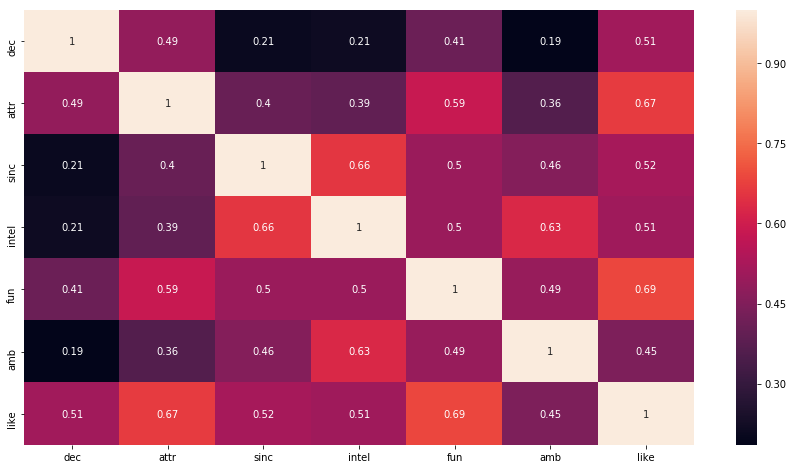

In [333]:
plt.figure(figsize=(15,8))
sns.heatmap(training.corr(), annot=True)

In [334]:
# plt.figure(figsize=(20,10))
# sns.pairplot(training)

In [381]:
label = training_features[0]
sc = StandardScaler()

X = training.drop(columns=label).values
X = sc.fit_transform(X)

y = training[label].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

### Dense NN

In [382]:
model = Sequential()
model.add(Dense(10, activation='relu', kernel_initializer="normal",
                input_dim=X_train.shape[1]))
model.add(Dense(50, activation='relu', kernel_initializer="normal"))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [383]:
# model.summary()

In [384]:
hist = model.fit(X_train, y_train, epochs=15, verbose=0)

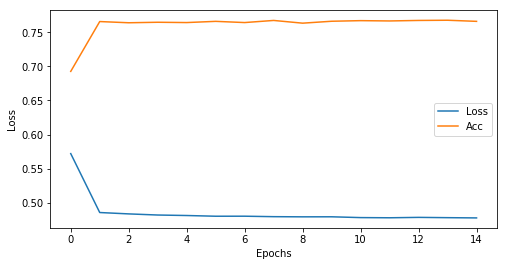

In [385]:
plt.figure(figsize=(8,4))
plt.plot(hist.history["loss"], label="Loss")
plt.plot(hist.history["acc"], label="Acc")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [386]:
y_pred = model.predict(X_test, batch_size=128)
# print(y_pred[:5])

In [387]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Accuracy: {acc}, loss: {loss}")

753/753 [==============================] - 1s 981us/step
Accuracy: 0.7795484729338769, loss: 0.4752280524527409


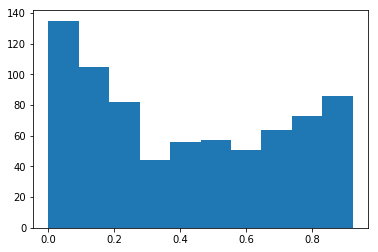

In [388]:
plt.hist(y_pred)
plt.show()

In [400]:
y = (y_pred > .5)
cm = confusion_matrix(y_test, y)
accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
print(cm)
print(accuracy)

[[359  78]
 [ 88 228]]
0.7795484727755644
